# Deteksi URL Phishing dengan menggunakan metode Machine Learning: Random Forest

### 1. Import Library

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

### 2. Load Dataset

In [6]:
df = pd.read_csv('dataset/alldata.csv')
df = df.drop(['Domain'], axis=1) #Drop domain karena domain bukan merupakan features

In [7]:
df.head()

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Label
0,0,0,1,3,0,0,0,0,0
1,0,0,1,3,0,0,0,0,0
2,0,0,1,3,0,0,0,0,0
3,0,0,1,3,0,0,0,0,0
4,0,0,1,3,0,0,0,0,0


### 3. Cek NaN Value

In [8]:
df.isnull().sum()

Have_IP          0
Have_At          0
URL_Length       0
URL_Depth        0
Redirection      0
https_Domain     0
TinyURL          0
Prefix/Suffix    0
Label            0
dtype: int64

In [9]:
df.describe()

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Label
count,50235.0,50235.000000,50235.000000,50235.000000,50235.000000,50235.000000,50235.000000,50235.000000,50235.000000
mean,0.0,0.016144,0.865373,3.170339,0.012461,0.000119,0.082691,0.058505,0.295770
std,0.0,0.126031,0.341328,2.081067,0.110934,0.010928,0.275418,0.234698,0.456393
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.0,1.000000,1.000000,38.000000,1.000000,1.000000,1.000000,1.000000,1.000000


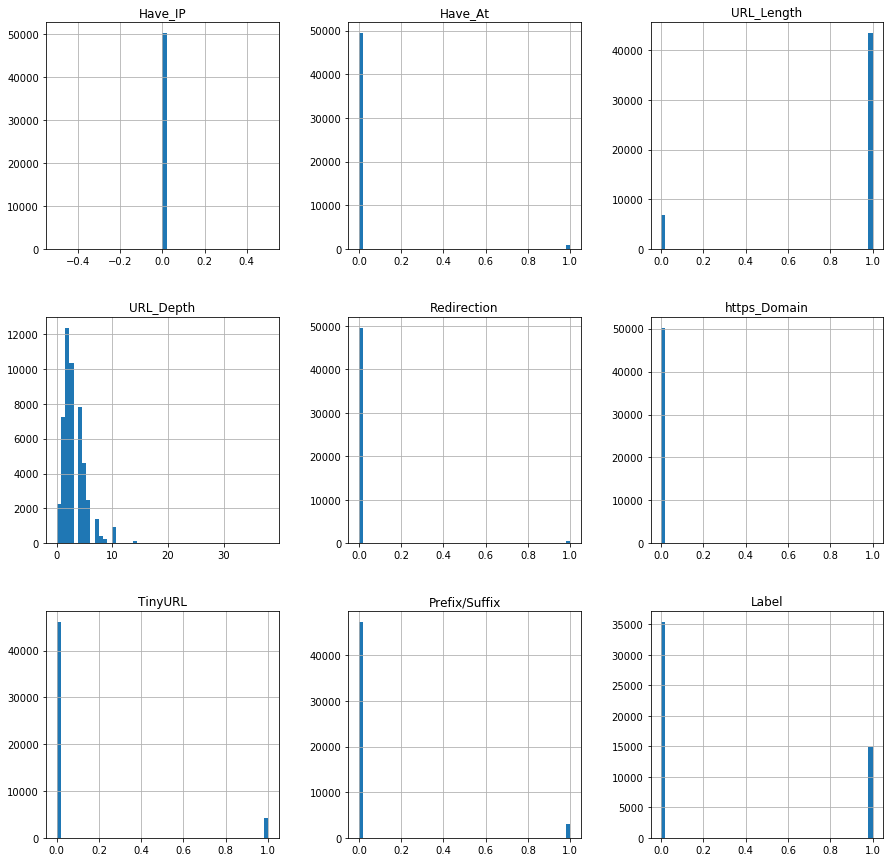

In [10]:
df.hist(bins = 50,figsize = (15,15));

### 4. Melihat Korelasi antar Fitur

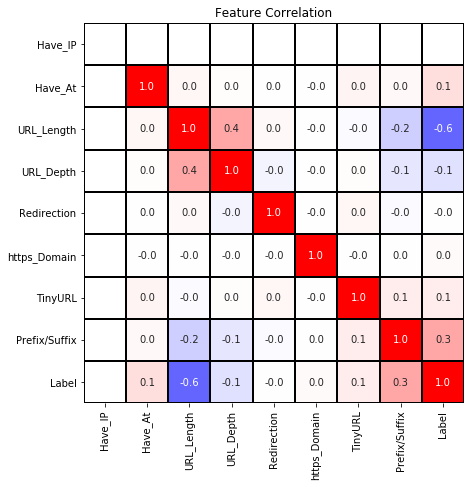

In [11]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), cmap="bwr", vmin=-1, vmax=1, square=True, annot=True, fmt=".1f",
            cbar=False, linewidths=1, linecolor='k')
plt.title("Feature Correlation");

Berdasarkan hasil korelasi antara Label dan semua fitur yang akan digunakan, terlihat hanya beberapa fitur saja yang memiliki korelasi yang baik dengan label. Diantaranya yaitu Fitur:

* Have_At = **0.1**
* URL_Length = **-0.6**
* URL_Depth = **-0.1**
* TinyURL = **0.1**
* Prefix/Suffix = **0.3**

Untuk itu pada project ini kita hanya akan menggunakan ke 5 fitur ini untuk melakukan klasifikasi

In [12]:
df = df[['Have_At', 'URL_Length', 'URL_Depth', 'TinyURL', 'Prefix/Suffix', 'Label']]

### 5. Mengacak Posisi Label

In [13]:
# Mengacak posisi dataset yang memiliki label 0 dan 1 agar saat di bagi data train dan test memiliki label yang seimbang
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Have_At,URL_Length,URL_Depth,TinyURL,Prefix/Suffix,Label
0,0,1,9,0,0,1
1,0,1,5,0,0,0
2,0,1,3,0,0,0
3,0,1,6,0,0,1
4,0,1,1,0,0,0


In [14]:
df.columns

Index(['Have_At', 'URL_Length', 'URL_Depth', 'TinyURL', 'Prefix/Suffix',
       'Label'],
      dtype='object')

### 6. Split Train dan Test Data

Membagi data untuk train dan test dengan komposisi data train 80% dari jumlah keseluruhan data, dan sisanya adalah data test.

In [15]:
X = df[['Have_At', 'URL_Length', 'URL_Depth', 'TinyURL', 'Prefix/Suffix']]
y = df.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40188, 5), (10047, 5), (40188,), (10047,))

### 7. Training Model

In [16]:
#Memisahkan fitur berupa numerical dan categorical
t = [('num', SimpleImputer(strategy='median'), ['URL_Depth']),
     ('cat', SimpleImputer(strategy='most_frequent'), ['Have_At', 'URL_Length', 'TinyURL', 'Prefix/Suffix'])]
transformer = ColumnTransformer(transformers=t)

In [17]:
#Beberapa parameter yang dapat di tunning pada Model Random Forest
params = {'algo__n_estimators': [100, 150, 200],
          'algo__max_depth': [20, 50, 80],
          'algo__max_features': [0.3, 0.6, 0.8],
          'algo__min_samples_leaf': [1, 5, 10]}

In [18]:
#Pipeline
pipeline = Pipeline([
    ('prep', transformer),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

In [19]:
model = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  2.2min finished


{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 150}
0.8788693142231512 0.8784463023788196 0.8774758634418234


### 8. Model Evaluation

#### Classification Report

In [20]:
print("Train report")
print(classification_report(y_train, model.predict(X_train)))
print()
print("Test report")
print(classification_report(y_test, model.predict(X_test)))

Train report
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     28302
           1       0.96      0.61      0.75     11886

    accuracy                           0.88     40188
   macro avg       0.91      0.80      0.84     40188
weighted avg       0.89      0.88      0.87     40188


Test report
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      7075
           1       0.97      0.61      0.75      2972

    accuracy                           0.88     10047
   macro avg       0.91      0.80      0.83     10047
weighted avg       0.89      0.88      0.87     10047



#### Confusion Matrix

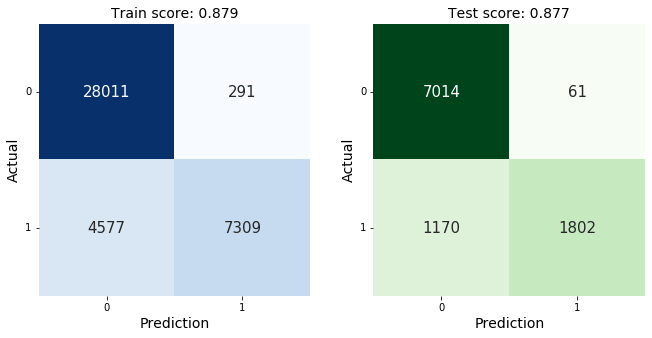

In [21]:
plt.figure(figsize=(11, 5))

plt.subplot(121)
labels = y_train.unique()
cm = confusion_matrix(y_train, model.predict(X_train), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'Train score: {model.score(X_train, y_train):.3f}', fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')

plt.subplot(122)
labels = y_test.unique()
cm = confusion_matrix(y_test, model.predict(X_test), labels=labels)
sns.heatmap(cm, annot=True, square=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels,
            fmt="d", annot_kws={"fontsize": 15})
plt.title(f'Test score: {model.score(X_test, y_test):.3f}', fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center');

Pada dua gambar diatas kita dapat mengetahui nilai kombinasi akurasi dan presisi pada dua dataset yaitu data train dan data test.

Pada data train didapatkan nilai sebagai berikut:
1. TP (True Positive) = 27942
2. TN (True Negative) = 7339
3. FP (False Positive) = 360
4. FN (False Negative) = 4547

Pada data test didapatkan nilai sebagai berikut:
1. TP (True Positive) = 6977
2. TN (True Negative) = 1878
3. FP (False Positive) = 98
4. FN (False Negative) = 1094



#### Feature Importance

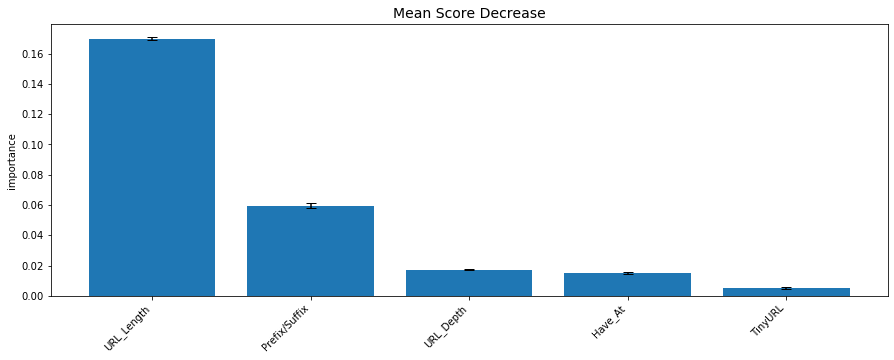

In [22]:
imp = permutation_importance(model, X_train, y_train, n_repeats=5, n_jobs=1, random_state=42)

df_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": imp["importances_mean"],
    "stdev": imp["importances_std"]
}).sort_values("importance", ascending=False)

plt.figure(figsize=(15, 5))
plt.bar(range(len(df_imp)), df_imp.importance, yerr=df_imp.stdev, error_kw={"capsize": 5})
plt.xticks(range(len(df_imp)), df_imp.feature, rotation=45, horizontalalignment='right')
plt.ylabel('importance')
plt.title("Mean Score Decrease", fontsize=14);

Dari grafik ini dapat kita simpulkan bahwa, fitur URL_Lenght merupakan fitur yang sangat berpengaruh dalam menentukan apakah sebuah URL diklasifikasikan sebagai Phising atau Legitimate, diikuti oleh fitur prefix/suffix, URL_Depth, Have_At, dan TinyURL

### 9. Save Model

In [23]:
model_name = "model/model.pkl"
with open(model_name, 'wb') as file:
    pickle.dump(model, file)

##### Try model

In [24]:
with open("model/model.pkl", 'rb') as file:
    load_model = pickle.load(file)

In [25]:
score = load_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
y_predict = load_model.predict(X_test)

Test score: 87.75 %


__FINAL__